# Propensity Score Matcing

In [35]:
#import packages
import pandas as pd
import numpy as np
import seaborn as sns
import scipy
import matplotlib.pyplot as plt
import matplotlib.style as style
import statsmodels.api as sm
import warnings
from causalinference import CausalModel
warnings.filterwarnings('ignore')

style.use('fivethirtyeight')

In [2]:
#import dataset
df = pd.read_csv('lalonde.csv')
df.head()

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
0,1,37,11,1,0,1,1,0.0,0.0,9930.0460
1,1,22,9,0,1,0,1,0.0,0.0,3595.8940
2,1,30,12,1,0,0,0,0.0,0.0,24909.4500
3,1,27,11,1,0,0,1,0.0,0.0,7506.1460
4,1,33,8,1,0,0,1,0.0,0.0,289.7899


In [3]:
#looking for averages per group

df.groupby('treat').mean()

,age,educ,black,hispan,married,nodegree,re74,re75,re78
treat,,,,,,,,,
0,28.030303,10.235431,0.202797,0.142191,0.512821,0.596737,5619.236506,2466.484443,6984.169742
1,25.816216,10.345946,0.843243,0.059459,0.189189,0.708108,2095.573689,1532.055314,6349.143530


#### T-test

In [4]:
#list with continous variables
confounders_list = ['age', 'educ', 're74', 're75']

In [5]:
#empty dic
t_test_results = {}

#loop
for x in confounders_list:
    group1 = df[df['treat'] == 0].dropna()[x]
    group2 = df[df['treat'] == 1].dropna()[x]
    
    #append to dic
    t_test_results[x] = scipy.stats.ttest_ind(group1, group2)
    
results = pd.DataFrame.from_dict(t_test_results, orient = 'Index')
results.columns = ['statistic', 'p_value']
    

In [6]:
results

,statistic,p_value
age,2.559013,1.073633e-02
educ,-0.477747,6.330010e-01
re74,6.381464,3.464585e-10
re75,3.248551,1.223444e-03


#### isolating treat and cofounders

In [7]:
treat = df[['treat']]
confounders = df.iloc[:, 1:-1]

#### log reg

In [8]:
confounders = sm.add_constant(confounders)
propensity_model = sm.Logit(treat, confounders).fit()

Optimization terminated successfully.
         Current function value: 0.397267
         Iterations 7


In [9]:
propensity_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  treat   No. Observations:                  614
Model:                          Logit   Df Residuals:                      605
Method:                           MLE   Df Model:                            8
Date:                Mon, 13 Mar 2023   Pseudo R-squ.:                  0.3508
Time:                        05:33:00   Log-Likelihood:                -243.92
converged:                       True   LL-Null:                       -375.75
Covariance Type:            nonrobust   LLR p-value:                 2.194e-52
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -4.7286      1.017     -4.649      0.000      -6.722      -2.735
age            0.0158      0.014      1.162      0.245      -0.011       0.042
educ           0.1613      0.065      2.477      0.013       0.034       0.289
black          3.0654      0.287     10.698      0.000       2.504       3.627
hispan         0.9836      0.426      2.311      0.021       0.149       1.818
married       -0.8321      0.290     -2.866      0.004      -1.401      -0.263
nodegree       0.7073      0.338      2.095      0.036       0.045       1.369
re74       -7.178e-05   2.87e-05     -2.497      0.013      -0.000   -1.54e-05
re75        5.345e-05   4.63e-05      1.153      0.249   -3.74e-05       0.000
==============================================================================
"""

#### predicting the propensity to be treated 

In [10]:
propensity_socre = propensity_model.predict(confounders)
propensity_socre

0      0.638770
1      0.224634
2      0.678244
3      0.776324
4      0.701639
         ...   
609    0.123144
610    0.034560
611    0.183351
612    0.383032
613    0.089712
Length: 614, dtype: float64

In [11]:
#create df

propensity_df = treat.copy()
propensity_df['propensity_score'] = propensity_socre
propensity_df

,treat,propensity_score
0,1,0.638770
1,1,0.224634
2,1,0.678244
3,1,0.776324
4,1,0.701639
...,...,...
609,0,0.123144
610,0,0.034560
611,0,0.183351
612,0,0.383032


In [12]:
#split df

non_treated = propensity_df[propensity_df['treat'] == 0][['propensity_score']]
treated = propensity_df[propensity_df['treat'] == 1][['propensity_score']]

#check
display(non_treated.head())
display(treated.head())

,propensity_score
185,0.026118
186,0.015993
187,0.026004
188,0.038500
189,0.432900


,propensity_score
0,0.638770
1,0.224634
2,0.678244
3,0.776324
4,0.701639


#### Commom Support Region

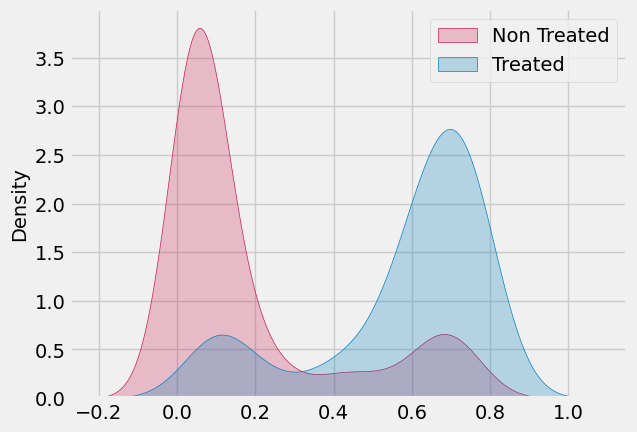

In [32]:
plot_non_treated = sns.kdeplot(non_treated, 
                               palette = "rocket",
                               shade = True,
                               label = 'Non Treated')

plot_non_treated = sns.kdeplot(treated, 
                               palette = "winter",
                               shade = True,
                               label = 'Treated')

plt.legend()
plt.show()

In [33]:
#isolate Y, treat and confounders


treat = df[['treat']].values
confounders = df.iloc[:, 1:-1].values
y = df.iloc[:,-1].values


#### PSM

In [37]:
propensity_model = CausalModel(y, treat, confounders)
propensity_model.est_propensity_s()
propensity_model.est_via_matching(bias_adj = True)

In [38]:
print(propensity_model.estimates)


Treatment Effect Estimates: Matching

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE   -444.122   1599.269     -0.278      0.781  -3578.690   2690.446
           ATC   -722.201   2021.846     -0.357      0.721  -4685.019   3240.617
           ATT    200.720   1779.421      0.113      0.910  -3286.945   3688.385



In [39]:
print(propensity_model.propensity)


Estimated Parameters of Propensity Score

                    Coef.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
     Intercept    -21.096      2.687     -7.851      0.000    -26.363    -15.829
            X2      2.635      0.367      7.179      0.000      1.915      3.354
            X4     -3.026      0.717     -4.222      0.000     -4.431     -1.621
            X6      0.000      0.000      0.847      0.397     -0.000      0.000
            X3      5.137      1.845      2.785      0.005      1.521      8.753
            X1      1.175      0.316      3.713      0.000      0.555      1.796
            X5      0.376      0.450      0.836      0.403     -0.505      1.258
            X7      0.000      0.000      1.496      0.135     -0.000      0.000
            X0      0.988      0.142      6.983      0.000      0.711      1.266
         X0*X0     -0.015      0.002     -6.524      0.000     -0.